## Load in the data

In [47]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
NUM_MICE_FREEZE = 3
NUM_MICE_FEED = 3
from MPNeuro.plotting import prettify_axes
import importlib

In [48]:
import matplotlib as mpl
mpl.rc('font', size = 20)
color_dict = {5: 'blue', 20:'red', 40:'black', 0:'orange'}
mpl.rc('lines', linewidth=3)

In [49]:
col_names = ['a', 'b', 'time', 'freq', 'mouse_id', 'train_test', 'distance', 'immobile_dur', 'c']
#freeze_df = pd.read_csv('CalcRL freezing.csv', sep = ';', encoding='utf-16', skiprows=4, header=None)
freeze_df = pd.read_csv('2016-Mar CalcRL frequency dependent freezing2.csv', sep = ';', encoding='utf-16', skiprows=4, header=None)
#freeze_df = pd.read_csv('2016-Feb CalcRL frequency dependent freezing2.csv', sep = ';', encoding='utf-16', skiprows=4, header=None)
freeze_df.columns = col_names
freeze_df.drop(freeze_df.columns[-1], axis = 1, inplace=True)
freeze_df.sort_values(by = ['freq', 'train_test', 'mouse_id', 'time'], inplace=True)
freeze_df.head()

,a,b,time,freq,mouse_id,train_test,distance,immobile_dur
142,Result 1,Trial 10,0:00:30-0:01:00,20Hz,MP135,24hr Test,132.4800,3.66663
143,Result 1,Trial 10,0:01:00-0:01:30,20Hz,MP135,24hr Test,83.7409,9.53332
144,Result 1,Trial 10,0:01:30-0:02:00,20Hz,MP135,24hr Test,99.8640,5.33333
141,Result 1,Trial 10,Start-0:00:30,20Hz,MP135,24hr Test,144.3720,4.93336
146,Result 1,Trial 11,0:00:30-0:01:00,20Hz,MP136,24hr Test,59.2885,21.33330


In [50]:
one_min_sum = freeze_df['immobile_dur'] + np.roll(freeze_df['immobile_dur'], -1)
freeze_df['immobile_roll_sum'] = one_min_sum

In [51]:
grouped_df_mean= freeze_df.groupby(['time', 'freq', 'train_test']).mean()
#grouped_df_mean.drop('mouse_id', axis = 1, inplace=True)
grouped_df_mean.index = grouped_df_mean.index.swaplevel(0, 2)
grouped_df_mean.index = grouped_df_mean.index.swaplevel(0, 1)
grouped_df_mean.sortlevel(level = ['freq', 'train_test', 'time'], inplace=True)
grouped_df_mean.head(3)

distance  immobile_dur  immobile_roll_sum
freq train_test time                                                       
20Hz 24hr Test  0:00:30-0:01:00  86.026567     12.999977          28.111083
                0:01:00-0:01:30  66.859100     15.111107          26.866650
                0:01:30-0:02:00  84.327950      9.466665          23.800095

In [52]:
grouped_df_std = freeze_df.groupby(['time', 'freq', 'train_test']).std()
#grouped_df_std.drop('mouse_id', axis = 1, inplace=True)
#grouped_df_std.columns = ['dist_std', 'immobile_std']
grouped_df_std.index = grouped_df_std.index.swaplevel(0, 2)
grouped_df_std.index = grouped_df_std.index.swaplevel(0, 1)
grouped_df_std.sortlevel(inplace=True)
grouped_df_std.head(2)

distance  immobile_dur  immobile_roll_sum
freq train_test time                                                       
20Hz 24hr Test  0:00:30-0:01:00  40.382802      8.875688          13.631730
                0:01:00-0:01:30  16.170663      4.880961          10.413665

## Plot freezing during training

In [53]:
mov_40Hz = grouped_df_mean.loc['40Hz', 'Train'].immobile_dur
mov_40Hz = np.roll(mov_40Hz, 1) 
mov_20Hz = grouped_df_mean.loc['20Hz', 'Train'].immobile_dur
mov_20Hz = np.roll(mov_20Hz, 1) 
mov_5Hz = grouped_df_mean.loc['5Hz', 'Train'].immobile_dur
mov_5Hz = np.roll(mov_5Hz, 1)

mov_40Hz_std = grouped_df_std.loc['40Hz', 'Train'].immobile_dur
mov_40Hz_std = np.roll(mov_40Hz_std, 1) / np.sqrt(NUM_MICE_FREEZE)
mov_20Hz_std = grouped_df_std.loc['20Hz', 'Train'].immobile_dur
mov_20Hz_std = np.roll(mov_20Hz_std, 1) / np.sqrt(NUM_MICE_FREEZE)
mov_5Hz_std = grouped_df_std.loc['5Hz', 'Train'].immobile_dur
mov_5Hz_std = np.roll(mov_5Hz_std, 1)/ np.sqrt(NUM_MICE_FREEZE)

In [54]:
mov_20Hz.shape

(17,)

### Plotting parameters

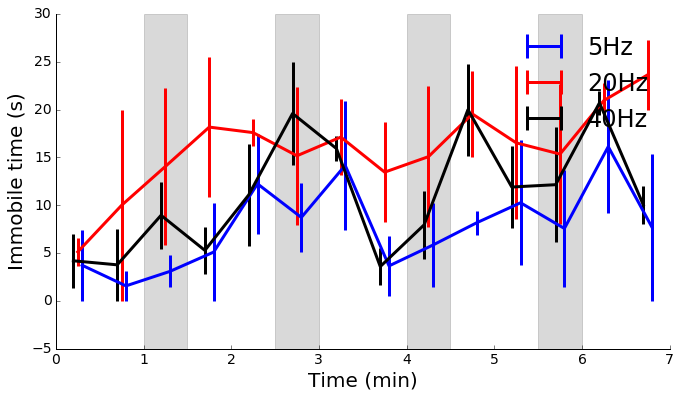

In [55]:
fig, ax = plt.subplots(1, figsize=[11, 6])
last_index =14
time_indices = np.arange(last_index) / 2+0.25
plt.errorbar(time_indices+0.05, mov_5Hz[:last_index], mov_5Hz_std[:last_index], label = '5Hz', capsize = 0, color=color_dict[5])
plt.errorbar(time_indices, mov_20Hz[:last_index], mov_20Hz_std[:last_index], label = '20Hz', capsize = 0, color=color_dict[20])
plt.errorbar(time_indices-0.05, mov_40Hz[:last_index], mov_40Hz_std[:last_index], label = '40Hz', capsize = 0, color=color_dict[40])
laser_times = [[1, 1.5], [2.5, 3], [4, 4.5], [5.5, 6]]
for cur_laser in laser_times:
    plt.axvspan(cur_laser[0], cur_laser[1], facecolor =  'k', alpha = 0.15)
    
plt.legend(frameon = False)
prettify_axes(plt.gca())
plt.xlabel('Time (min)')
plt.ylabel('Immobile time (s)');
fig.savefig('Training timecourse.png')

## Plot freezing during test

Calculate means

In [57]:
test_40Hz_mean = grouped_df_mean.loc['40Hz', '24hr Test'].immobile_roll_sum 
test_40Hz_mean = np.roll(test_40Hz_mean, 1)
test_20Hz_mean = grouped_df_mean.loc['20Hz', '24hr Test'].immobile_roll_sum
test_20Hz_mean = np.roll(test_20Hz_mean, 1)
test_5Hz_mean = grouped_df_mean.loc['5Hz', '24hr Test'].immobile_roll_sum
test_5Hz_mean = np.roll(test_5Hz_mean, 1)
#test_0Hz_mean = grouped_df_mean.loc['0Hz', '0hr Test'].immobile_roll_sum
#test_0Hz_mean = np.roll(test_0Hz_mean, 1)

Calculate std's

In [59]:
test_40Hz_ste = grouped_df_std.loc['40Hz', '24hr Test'].immobile_roll_sum / np.sqrt(NUM_MICE_FREEZE)
test_40Hz_ste = np.roll(test_40Hz_ste, 1)
test_20Hz_ste = grouped_df_std.loc['20Hz', '24hr Test'].immobile_roll_sum / np.sqrt(NUM_MICE_FREEZE)
test_20Hz_ste = np.roll(test_20Hz_ste, 1)
test_5Hz_ste = grouped_df_std.loc['5Hz', '24hr Test'].immobile_roll_sum / np.sqrt(NUM_MICE_FREEZE)
test_5Hz_ste = np.roll(test_5Hz_ste, 1)
#test_0Hz_ste = grouped_df_std.loc['0Hz', '0hr Test'].immobile_roll_sum / np.sqrt(NUM_MICE_FREEZE)
#test_0Hz_ste = np.roll(test_0Hz_ste, 1)

In [ ]:
test_0Hz_mean.shape

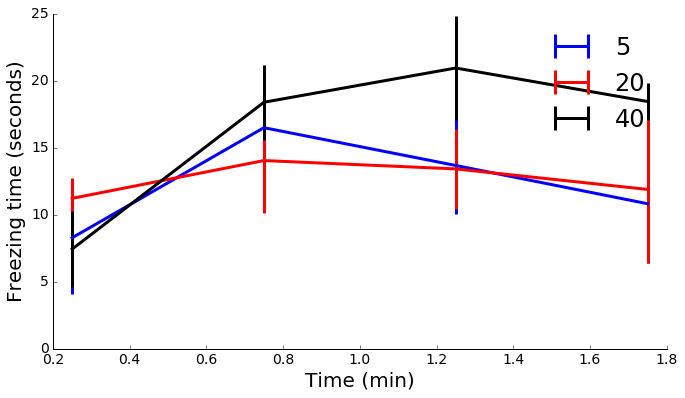

In [60]:
fig, ax = plt.subplots(1, figsize=[11, 6])
last_index =4
time_indices = np.arange(last_index) / 2+0.25
#plt.errorbar(time_indices[:4], test_0Hz_mean[:4] / 2, test_0Hz_ste[:4] / 2, label = '0', color=color_dict[0], capsize = 0)
plt.errorbar(time_indices, test_5Hz_mean[:last_index] / 2, test_5Hz_ste[:last_index] / 2, label = '5', color=color_dict[5], capsize = 0)
plt.errorbar(time_indices, test_20Hz_mean[:last_index] / 2, test_20Hz_ste[:last_index] / 2, label = '20', color=color_dict[20], capsize = 0)
plt.errorbar(time_indices, test_40Hz_mean[:last_index] / 2, test_40Hz_ste[:last_index] / 2, label = '40', color=color_dict[40], capsize = 0)
plt.legend(frameon = False)
plt.xlabel('Time (min)')
plt.ylabel('Freezing time (seconds)')
prettify_axes(plt.gca())
fig.savefig('Testing timecourse.png')

NameError: name 'test_0Hz_mean' is not defined

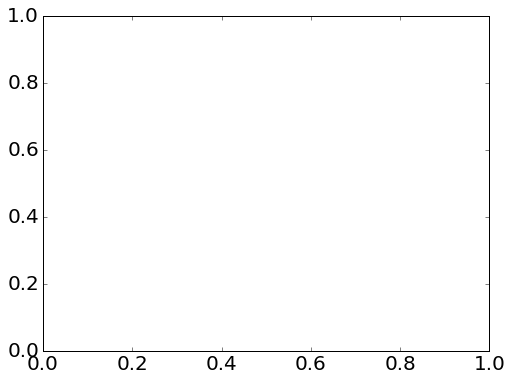

In [61]:
fig, ax = plt.subplots(1, figsize = [8, 6])
freeze_indices = np.array([0,  5, 20, 40])
freq_means = np.array([test_0Hz_mean[0], test_5Hz_mean[0], test_20Hz_mean[0], test_40Hz_mean[0]]) * 6 / 5
freq_stes = np.array([test_0Hz_ste[0],  test_5Hz_ste[0], test_20Hz_ste[0], test_40Hz_ste[0]])* 6 / 5
plt.errorbar(freeze_indices, freq_means, freq_stes, capsize = 0, color = 'red')
plt.xlim([-1, 50])
plt.ylim([0, 60])
plt.ylabel('Immobile duration (first minute)', fontsize = 20)
plt.xlabel('Stimulation frequency (Hz)', fontsize = 20)
plt.xticks([0,1,5,10,20,40])
prettify_axes(plt.gca())
fig.savefig('Frequency vs immobility.png')

# CalcRL feeding

In [ ]:
#feed_df = pd.read_csv('CalcRL feeding lick times - retry.csv', sep=';')
feed_df = pd.read_csv('2016 CalcRL feeding frequency.csv', sep=';')
feed_df.head()

In [ ]:
feed_df['duration'] = feed_df.stop - feed_df.start
feed_df.head(3)

In [ ]:
sum_feed_df = feed_df.groupby(['mouse', 'Hz']).sum()
sum_feed_df.head(3)

In [ ]:
mean_mouse_feed_df = sum_feed_df.groupby(level = 'Hz').mean()
std_mouse_feed_df = sum_feed_df.groupby(level = 'Hz').std()
mean_mouse_feed_df.head()

In [ ]:
fig, ax = plt.subplots(1, figsize=[8, 6])
freeze_indices = np.array([0,  5, 20, 40])
freq_means = np.array([test_0Hz_mean[0], test_5Hz_mean[0], test_20Hz_mean[0], test_40Hz_mean[0]] )/ 48
freq_stes = np.array([test_0Hz_ste[0],  test_5Hz_ste[0], test_20Hz_ste[0], test_40Hz_ste[0]] ) / 48
plt.errorbar(freeze_indices,  100 *freq_means,  100 *freq_stes, label = 'Freezing', color = 'r', capsize = 0)

feed_indices = np.array([0, 1, 5, 20, 40])
max_duration =  mean_mouse_feed_df['duration'][0]
plt.errorbar(feed_indices, 100 *mean_mouse_feed_df['duration'] / max_duration,
              100 *std_mouse_feed_df['duration'] / (max_duration * np.sqrt(NUM_MICE_FEED)),
            label = 'Feeding', color = 'b', capsize = 0)
plt.xlim([-1, 50])
plt.ylim([0, 140])

plt.ylabel('Freeze duration (% of time)\nFeeding duration (% of 0Hz)')
plt.xlabel('Stimulation frequency (Hz)')
plt.xticks([0,1,5,10,20,40])
prettify_axes(plt.gca())
plt.legend(loc='upper right', frameon=False);
fig.savefig('CalcRL Freezing vs Feeding.png');

In [ ]:
fig, ax = plt.subplots(1, figsize=[8, 6])
feed_indices = np.array([0, 1, 5, 20, 40])
max_duration =  mean_mouse_feed_df['duration'][0]
plt.errorbar(feed_indices, 100 *mean_mouse_feed_df['duration'] / max_duration,
              100 *std_mouse_feed_df['duration'] / (max_duration * np.sqrt(NUM_MICE_FEED)),
            label = 'Feeding', color = 'b', capsize = 0)
plt.xlim([-1, 50])
plt.ylim([0, 140])

plt.ylabel('Feeding duration (% of 0Hz)')
plt.xlabel('Stimulation frequency (Hz)')
plt.xticks([0,1,5,10,20,40])
prettify_axes(plt.gca())
#plt.legend(loc='lower right', frameon=False, fontsize = fs-4);
fig.savefig('CalcRL Freezing vs Feeding.png');

In [ ]:
sum_feed_df